In [33]:
import pandas as pd
import seaborn as sns

from scipy.stats import ttest_ind 
from scipy.stats import chi2_contingency
from scipy.stats import levene
from scipy.stats import normaltest

sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize': (20, 7)}
)

path_to_file = "/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-kesarev/ab_data.csv"

# Тестовое задание №1. 
# Анализ результатов A/B теста:

## Подгружаем датафрейм, импортим библиотеки, проверяем данные на пропуски.

In [2]:
df = pd.read_csv(path_to_file, sep=';')
df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [3]:
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [4]:
df.user_id.nunique()

404770

# Смотрим ARPU и медиану, строим histplot для наглядности расположения значений.

In [5]:
df.groupby('testgroup', as_index=False).\
agg({'revenue': 'mean', 'user_id': 'count'}).\
rename(columns={'user_id': 'users_count'})

,testgroup,revenue,users_count
0,a,25.413720,202103
1,b,26.751287,202667


### ARPU в группе b больше.

In [6]:
df.groupby('testgroup', as_index=False).\
agg({'revenue': 'median', 'user_id': 'count'}).\
rename(columns={'user_id': 'users_count'})

,testgroup,revenue,users_count
0,a,0,202103
1,b,0,202667


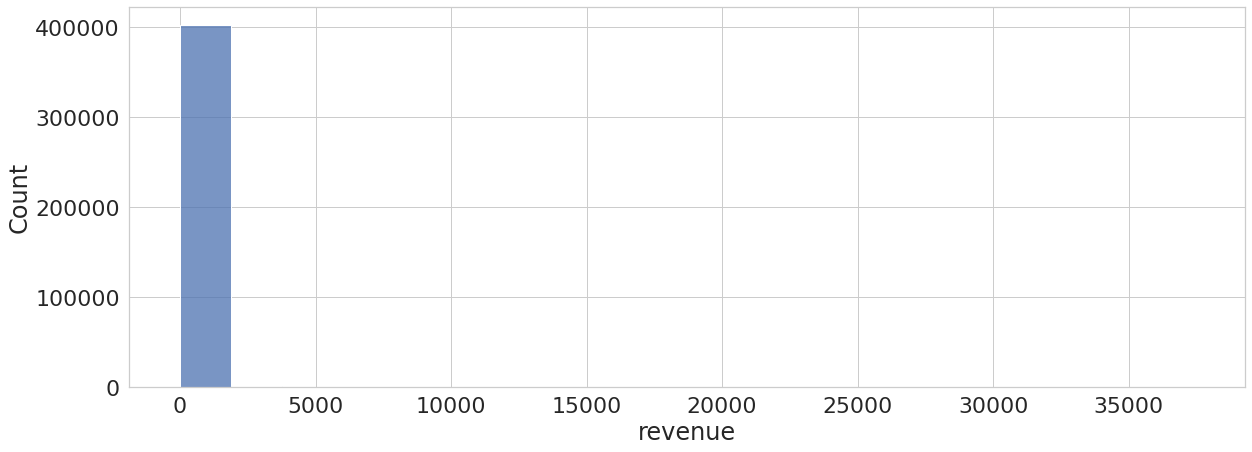

In [7]:
sns.histplot(df, x='revenue')

## Revenue большинства пользователей равен 0.

# Посмотрим на CR и статзначимость различий CR между групп.

## Подготовим данные для тестов.

In [8]:
df['paying_user'] = df.revenue.apply(lambda x: x != 0)

In [9]:
a_CR = df.query("revenue > 0 and testgroup == 'a'").user_id.count() / df.query("testgroup == 'a'").user_id.count() * 100
b_CR = df.query("revenue > 0 and testgroup == 'b'").user_id.count() / df.query("testgroup == 'b'").user_id.count() * 100

In [10]:
paying_users_crosstab = pd.crosstab(df.testgroup,df.paying_user)
paying_users_crosstab

paying_user,False,True
testgroup,,
a,200175,1928
b,200862,1805


### H0 : (нулевая гипотеза) Разница между CR у группы a и группы b не статзначима.
### H1 : (альтернативная гипотеза) Различия CR у группы a и группы b статзначима.
### Уровень значимости 95%.

In [11]:
print(chi2_contingency(paying_users_crosstab)[1])

0.03647561892312613


### p-value = 3%. 
### p-value < 5% - значит нулевая гипотеза отклоняется и можно сказать, что различие CR статзначимо.

In [12]:
print(a_CR, b_CR)

0.9539690157988748 0.8906235351586593


## Исходя из результатов теста мы видим, что CR  в группе a больше на 0.06%.
## И это различие является статзначимым.

# Учитывая данные, полученные ранее, интересно посмотреть на ARPPU и медианное значение revenue для платящих пользователей.

In [13]:
df.query('revenue > 0').groupby('testgroup', as_index=False).\
agg({'revenue': 'mean', 'user_id': 'count'}).\
rename(columns={'user_id': 'users_count'})

,testgroup,revenue,users_count
0,a,2663.998444,1928
1,b,3003.658172,1805


In [14]:
df.query('revenue > 0').groupby('testgroup', as_index=False).\
agg({'revenue': 'median', 'user_id': 'count'}).\
rename(columns={'user_id': 'users_count'})

,testgroup,revenue,users_count
0,a,311,1928
1,b,3022,1805


# ARPPU и медианное revenue для платящих пользователей куда сильнее различается между группами, в сравнении с  ARPU. Особенно выделяется медиана.
## Посмотрим распределение revenue для каждой группы.

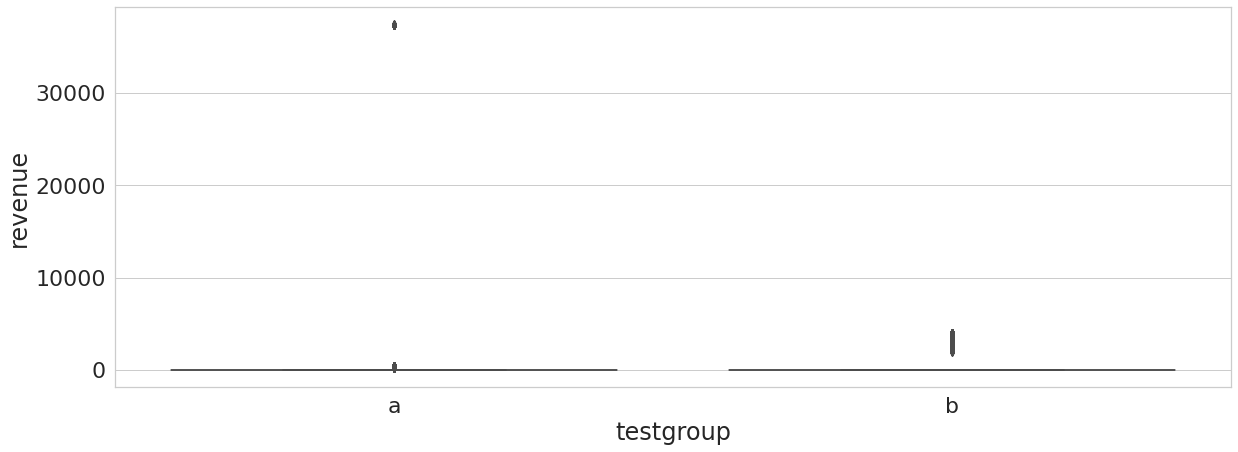

In [15]:
sns.boxplot(data=df, x='testgroup', y='revenue', order=['a', 'b'])

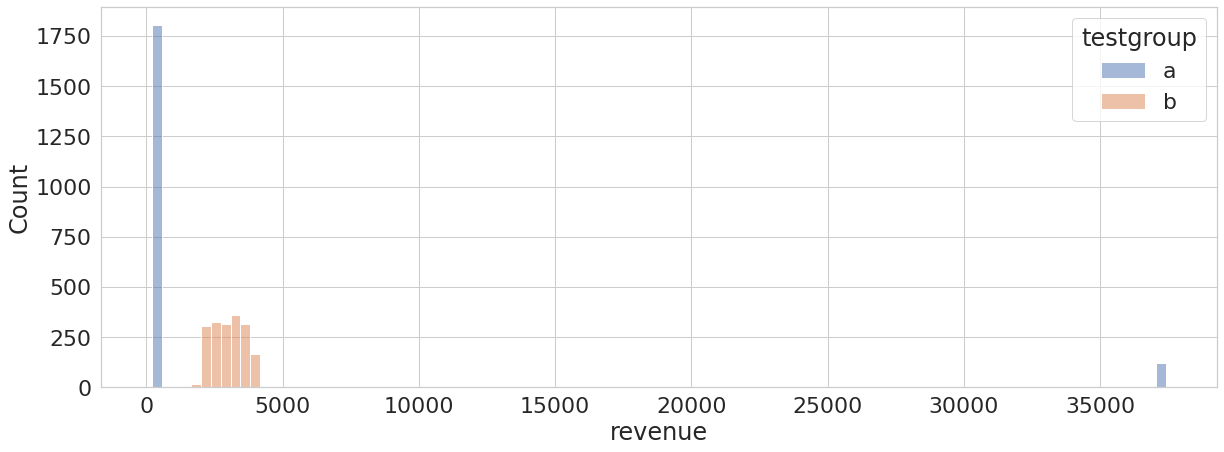

In [16]:
sns.histplot(df.query('revenue > 0'), x='revenue', hue='testgroup')

In [17]:
df.query("testgroup == 'a' and revenue > 0").revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [18]:
df.query("testgroup == 'b' and revenue > 0").revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

In [19]:
df.query("testgroup == 'a' and revenue > 0").revenue.mode()

0    206
1    310
dtype: int64

In [20]:
df.query("testgroup == 'b' and revenue > 0").revenue.mode()

0    2003
dtype: int64

# Распределение revenue в группе a имеет очень большое стандартное отклонение и почти все значения меньше, чем минимум в группе b.
## Однако есть и очень большие значения, вплоть до 37 тысяч, хоть их количество и не большое. Я не считаю, что эти значения - выброс, но 75ый процентиль равен всего лишь 361.

# В группе b распределение очень сильно отличается от группы a, значения имеют небольшой разброс(std всего 572, против 9049 у группы a) и находятся в диапазоне от 2000 до 4000.
## Значения в группе b куда стабильней. Максимум сильно ниже, но среднее revenue все равно выше, чем в группе a. 

# Кажется, что группа b показала себя лучше, чем группа a. Осталось проверить статзначимость этих значений и теста в целом.
### Для начала проверим нормальность распределения(несмотря на то, что их ненормальность видно на графике) и гомогенность дисперсий у ARPU и ARPPU

### Проверим нормальность распределения групп у ARPU и ARPPU

In [35]:
normaltest(df.query('testgroup == "a"').revenue)

NormaltestResult(statistic=585152.7312728433, pvalue=0.0)

In [36]:
normaltest(df.query('testgroup == "b"').revenue)

NormaltestResult(statistic=326622.39540856465, pvalue=0.0)

In [39]:
normaltest(df.query('revenue > 0 and testgroup == "a"').revenue)

NormaltestResult(statistic=1394.9457843086925, pvalue=1.2341605505935488e-303)

In [38]:
normaltest(df.query('revenue > 0 and testgroup == "b"').revenue)

NormaltestResult(statistic=1068.8600084412267, pvalue=7.943249488371762e-233)

### P-value во всех тестах < 0.05, что говорит о том, что распределения у групп не являются нормальными, как для ARPU, так и для ARPPU.

## Теперь проверим однородность дисперсий групп для ARPU с помощью критерия Левена.
### H0 : (нулевая гипотеза) Дисперсии гомогенны 
### H1 : (альтернативная гипотеза) Дисперсии не гомогенны.

In [30]:
levene(df.query('testgroup == "a"').revenue, df.query('testgroup == "b"').revenue)

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

### P-value > 0.05 и мы подтверждаем нулевую гипотезу для ARPU. Учитывая однородность дисперсий, мы можем использовать ттест для проверки статзначимости различий ARPU у групп.
### H0 : (нулевая гипотеза) Различия между ARPU у группы a и группы b не статзначимы.
### H1 : (альтернативная гипотеза) Различия ARPU у группы a и группы b статзначимы.

In [40]:
ttest_ind(df.query('testgroup == "a"').revenue,
          df.query('testgroup == "b"').revenue)

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

### P-value > 0.05, значит мы принимаем нулевую гипотезу и ARPU у групп различается не статзначимо.

## Теперь проверим однородность дисперсий групп для ARPPU с помощью критерия Левена.
### H0 : (нулевая гипотеза) Дисперсии гомогенны 
### H1 : (альтернативная гипотеза) Дисперсии не гомогенны.

In [42]:
levene(df.query('revenue > 0 and testgroup == "a"').revenue, df.query('revenue > 0 and testgroup == "b"').revenue)

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

### P-value < 0.05 и мы отклоняем нулевую гипотезу для ARPPU. Учитывая, что дисперсии не являются однородными, стоит использовать ттест Уэлча.
### H0 : (нулевая гипотеза) Различия между ARPPU у группы a и группы b не статзначимы.
### H1 : (альтернативная гипотеза) Различия ARPPU у группы a и группы b статзначимы.

In [44]:
ttest_ind(df.query('revenue > 0 and testgroup == "a"').revenue,
          df.query('revenue > 0 and testgroup == "b"').revenue, equal_var=False)

Ttest_indResult(statistic=-1.6446302664300838, pvalue=0.10020780398916015)

### P-value > 0.05, значит мы принимаем нулевую гипотезу и ARPU у групп различается не статзначимо.

# Итоги:

# a - контрольная группа.
# b - тестовая группа.
### *ARPU  - нет статзначимых различий между контрольной и тестовой группой.
### *ARPPU - нет статзначимых различий между контрольной и тестовой группой.
### *CR - на 0.06% выше в контрольной группе. Результат статзначим.

# Из результатов выше, можно сказать, что контрольная группа показала себя лучше, повысив CR, не понизив ARPU и ARPPU.

### **Так же стоит отметить, что данные кажутся не совсем корректными - т.к. в группах разные, непересекающиеся сегменты пользователей по величине оплат, то вероятно, что дизайн эксперимента нарушен и сплитование проведено некорректно. Но учитывая то, что всё что есть об этом тесте - это эти данные, то проверить гипотезу не получится.

# Тестовое задание №2.

# В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

# Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

# 1)Оценить результат события можно с помощью: 
## 1.DAU 
## 2. Retention
## 3.AVG плейтайма,
# Которые должны увеличиваться на время ивента.
# Так же стоит обратить внимание на: 
## 1.кол-во покупок(Purchases)  
## 2.AVG донат пользователя, 
# Т.к. скорее всего во время прохождения ивента можно покупать дополнительные жизни/время/бонусы, которые помогут в прохождении уровней  и они соответствено тоже должны увеличиваться. Эти метрики покажут успешность события.

# Дополнительно, я бы отслеживал: 
## 1.уровень, до которого доходят игроки
## 2.сколько попыток тратят на уровень 
## 3.после какого уровня чаще всего закрывают игру
## (чтобы не оказалось, что какой-то уровень непроходим или очень сложный и большинство пользователей отваливаются от ивента на нём) и среднее время прохождения ивента.

# 2) Я бы не стал добавлять дополнительные метрики для оценки результата, но более пристально смотрел за метриками прогресса и плейтайма, потому что от усложнения прогресса метрики могут увеличиться( больше времени для прохождения, больше раз нужно зайти, больше бонусов нужно купить в магазине и т.д.), но так же метрики могут и уменьшиться, если событие окажется слишком сложным или нудным для игроков.
